In [2]:
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
from datetime import datetime, timedelta
import seaborn as sns
sns.set_theme()

import ta
from tqdm import tqdm
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingRegressor, VotingClassifier, RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor
import pickle
from joblib import dump
import ast

import logging
import gc

import warnings
warnings.filterwarnings("ignore")

import estimation
mt5.initialize()

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

# Импорт списка доступных инструментов

In [3]:
def extract_symbols_info():
    """Извлечение информации о символах и создание df"""
    symbols = []
    sectors = []
    descriptions = []
    symbols_info = mt5.symbols_get()
    symbols_info_list = list(symbols_info)
    
    for element in symbols_info_list:
        symbols.append(list(element)[-3])
        sectors.append(list(element)[-1].split("\\")[0])
        descriptions.append(list(element)[-7])
    
    info_df = pd.DataFrame({
        "Symbol": symbols,
        "Sector": sectors,
        "Description": descriptions
    })
    
    print(f"Извлечено {len(symbols)} символов")
    return info_df

def calculate_spread(info_df):
    """Расчет спреда для каждого символа"""
    spreads = []
    
    for symbol in info_df["Symbol"]:
        try:
            tick_info = mt5.symbol_info_tick(symbol)
            if tick_info is not None:
                ask = tick_info.ask
                bid = tick_info.bid
                spread = (ask - bid) / bid
                spreads.append(spread)
            else:
                spreads.append(None)
                print(f"Нет спреда по символу: {symbol}")
        except Exception as e:
            print(f"Ошибка получения информации по символу {symbol}: {e}")
            spreads.append(None)
    
    info_df["Spread"] = spreads
    return info_df

def filter_low_spread(info_df, threshold=0.0007):
    """Фильтрация активов со спредом ниже указанного порога"""
    low_spread_assets = info_df.dropna().loc[info_df["Spread"] < threshold]
    low_spread_assets = low_spread_assets.sort_values(by="Spread")
    low_spread_assets = low_spread_assets[low_spread_assets.Sector != 'Forex-Pro']
    print(f"Найдено {len(low_spread_assets)} активов со спредом ниже {threshold}")
    return low_spread_assets


informations = extract_symbols_info()
informations_with_spread = calculate_spread(informations)
low_spread = filter_low_spread(informations_with_spread)

Извлечено 94 символов
Найдено 40 активов со спредом ниже 0.0007


# Функция загрузки данных

In [4]:
def get_rates(symbol, n, timeframe=mt5.TIMEFRAME_D1):
    """Функция, которая возвращает данные по символу"""
    
    # Инициализация устройства MetaTrader
    mt5.initialize()
    
    # Получение данных в df
    utc_from = datetime.now() + timedelta(hours=3)  # Текущее время терминала
    data = mt5.copy_rates_from(symbol, timeframe, utc_from, n)  
    rates_frame = pd.DataFrame(data)  
    
    # Преобразование времени из секунд в формат datetime
    rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')  
    rates_frame['time'] = pd.to_datetime(rates_frame['time'], format='%Y-%m-%d')  
    rates_frame['month'] = rates_frame['time'].dt.month  
    rates_frame['year'] = rates_frame['time'].dt.year  
    rates_frame = rates_frame.set_index('time')  
    rates_frame.dropna(inplace=True)  

    # Вычисление первой цены открытия каждого месяца и года
    rates_frame['first_open_month'] = rates_frame.groupby(['year', 'month'])['open'].transform('first')
    rates_frame['first_open_year'] = rates_frame.groupby(['year'])['open'].transform('first')
    # Вычисление сезонных отклонений
    rates_frame['seasons_month'] = ((rates_frame ["open"] - rates_frame["first_open_year"]) / rates_frame["first_open_year"] * 100)
    rates_frame['seasons_year'] = ((rates_frame ["open"] - rates_frame["first_open_month"]) / rates_frame["first_open_month"] * 100)

    # Вставка символа в df
    rates_frame.insert(0, 'symbol', symbol)
 
    # Удаление ненужных столбцов
    rates_frame.drop(['spread', 'real_volume', 'month', 'first_open_month', 'first_open_year'], axis=1, inplace=True)

    # Подсчет количества записей для каждого года
    year_counts = rates_frame['year'].value_counts()
    # Отбор годов, в которых количество записей меньше 250 или больше 270, за исключением текущего года
    years_to_remove = year_counts[((year_counts < 250) | (year_counts > 270)) & (year_counts.index != datetime.now().year)].index
    # Удаление строк с этими годами из df
    rates_frame = rates_frame[~rates_frame['year'].isin(years_to_remove)]

    return rates_frame

# Функция расчёта сезонности

На годовых отрезках рассчитаю сезонные колебания цен. За точку отсчёта возьму начало каждого года, а также начало каждого месяца. Сезонность рассчитаю как относительное отклонение от цены открытия на начало месяца/года.

In [5]:
def calculate_seasonal_averages(dataframe, periods=[2, 3], seas_col_names=['seasons_year', 'seasons_month']):
  """
  Эта функция рассчитывает среднее значение указанного столбца (seas_col_names) за 
  указанное количество предыдущих лет (periods) для колонок с рассчитанным отклонением цен (seas_col_names) 
  для каждого года в данных (dataframe).
  Функция применяется внутри функции features_engineering

  Args:
      df (pandas.DataFrame): Датафрейм, который вернула функция get_rates
      periods (list, optional): Список периодов, за которые нужно считать среднее. 
          По умолчанию [2, 5].
      seas_col_names (list, optional): Список названий столбцов с рассчитанными 
      ранее отклонениями цен. 
          По умолчанию ['seasons_year', 'seasons_month'].

  Returns:
      pandas.DataFrame: Исходные данные с добавленными столбцами для среднего значения 
          за каждый период по сезонам.
  """
  df= dataframe.copy()
  for p in periods:
    cnt_iter = len(df.year.unique()) - p  # Число итераций по годам

    for s_col_name in seas_col_names:
      years = np.sort(df.year.unique())[::-1]
      new_col_name = f'avg_{p}Y_{s_col_name}_predict'
      df[new_col_name] = np.nan  # Добавляем новый столбец с пустыми значениями

      for i in years[:cnt_iter]:
        # Фильтруем данные по текущему году
        df_y = pd.DataFrame(df[df.year == i].index)
        years = years[1:]

        # Используем срез years[1:] для выбора предыдущих p лет 
        # (кроме текущего года для избежания утечки данных)
        for j in range(p):
          df_y[f'{years[j]}_dates'] = pd.Series(
              df[df.year == years[j]].index[:len(df_y)], index=df_y.index[:len(df[df.year == years[j]])]
          ).reindex(df_y.index)

          # Объединяем даты по текущему году и данныe из предыдущих p лет
          df_y = pd.merge(
              left=df_y,
              right=df[s_col_name],
              how='left',
              left_on=df_y[f'{years[j]}_dates'],
              right_index=True,
              suffixes=(None, f'_{years[j]}')
          )

        # Удаляем строки с пустыми значениями
        df_y.dropna(inplace=True)

        # Рассчитываем усреднённое отклонение цен за последние p лет
        df_y[new_col_name] = df_y.filter(like=s_col_name).sum(axis=1) / p
        df_y.index = df_y.time
        df_y.drop('time', axis=1, inplace=True)

        # Обновляем исходные данные, добавляя среднее значение для текущего года
        df.loc[df_y.index, new_col_name] = df_y[new_col_name]

  return df


# Конструирование признаков

In [6]:
def features_engineering(df):

    """
    Добавление сезонных индикаторов,
    расчет технических индикаторов (например, полосы Боллинджера, RSI, ADX), создание лаговых переменных,
    нормализация данных и преобразование признаков с использованием PCA.
    
    Возвращает преобразованный DataFrame, целевые переменные для регрессии и классификации, а также признаки, разделенные 
    на обучающие, тестовые и валидационные выборки.

    Args:
        df (pandas.DataFrame): датафрейм, который вернула функция get_rates
    Returns:
      df : преобразованный датафрейм, который содержит данные по сезонности, 
            рассчитанные значения технических индикаторов, 'returns' - целевая переменная, стационарный ряд.
     Также функция возвращает некоторые другие преобразованные данные, которые применяются при обучении и тестировании моделей
     
    """

    # Добавлю сезонность и индикаторы
    df = calculate_seasonal_averages(df)

    df['BB_upper_predict']= ta.volatility.BollingerBands(df['close'], window=10, window_dev=1).bollinger_hband().shift(1)
    df['BB_middle_predict'] = ta.volatility.BollingerBands(df['close'], window=10, window_dev=1).bollinger_mavg().shift(1)
    df['BB_lower_predict'] = ta.volatility.BollingerBands(df['close'], window=10, window_dev=1).bollinger_lband().shift(1)
    df['RSI_predict'] = ta.momentum.RSIIndicator(df['close'], window=10).rsi().shift(1)
    df['ADX_predict'] = ta.trend.ADXIndicator(df['high'], df['low'], df['close'], window=3).adx().shift(1)
    df['EMA_predict'] = ta.trend.EMAIndicator(df['close'], window=550).ema_indicator().shift(1)
    df['A/D_predict'] = ta.volume.AccDistIndexIndicator(df['high'], df['low'], df['close'], df['tick_volume']).acc_dist_index().shift(1)
    
    # Вычисление уровней A/D
    def calculate_levels(series, window=14):
        rolling_mean = series.rolling(window=window).mean()
        rolling_std = series.rolling(window=window).std()
        upper_level = rolling_mean + (2 * rolling_std)
        lower_level = rolling_mean - (2 * rolling_std)
        return upper_level, lower_level

    # Добавление уровней в df
    df['A/D_upper_predict'], df['A/D_lower_predict'] = calculate_levels(df['A/D_predict'])

    # Процентное отклонение close от предыдущего значения 
    df['returns'] = df['close'].pct_change()
    # Процентное отклонение high и low от предыдущей цены закрытия
    df["shift_low"] = ((df["low"] - df["close"].shift(1)) / df["close"].shift(1))
    df["shift_high"] = ((df["high"] - df["close"].shift(1)) / df["close"].shift(1))

    variables = ['BB_upper_predict', 'BB_middle_predict', 'BB_lower_predict', 'RSI_predict', 
                'ADX_predict', 'EMA_predict', 'A/D_predict', 'A/D_upper_predict', 'A/D_lower_predict', 
                'returns']

    for var in variables:
        for i in range(1, 6):
            if var == 'returns':
                df[f'{var}_T-{i}_predict'] = df[var].shift(i)
            else:
                df[f'{var}_T-{i}'] = df[var].shift(i)

    # Удаление пропущенных значений
    df = df.dropna()

    # Фильтрация признаков
    df_X = df.filter(like='_predict')
    df_y = df[["returns"]]

    # Разделение данных на обучающую, тестовую и валидационную выборки
    split_train_test = int(0.70 * len(df))  # 70% данных для обучения 
    split_test_valid = int(0.85 * len(df))  # 15% данных для тестирования и 15% для валидации

    # Обучающая выборка
    X_train = df_X.iloc[:split_train_test]
    y_train_reg = df_y.iloc[:split_train_test]
    y_train_cla = np.round(y_train_reg + 0.5) #рост/падение

    # Тестовая выборка
    X_test = df_X.iloc[split_train_test:split_test_valid]

    # Валидационная выборка
    X_val = df_X.iloc[split_test_valid:]

    # Нормализация данных
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Стандартизация обучающих признаков
    X_test_scaled = scaler.transform(X_test)  # Стандартизация тестовых признаков
    X_val_scaled = scaler.transform(X_val)  # Стандартизация валидационных признаков

    # Инициализация PCA с 15 компонентами
    pca = PCA(n_components=15)

    # Преобразование признаков
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    X_val_pca = pca.transform(X_val_scaled)

    return df, y_train_reg, y_train_cla, X_train_pca, X_test_pca, X_val_pca, split_train_test, split_test_valid, \
        X_test.index[0], X_val.index[0]
    

# Поиск оптимальных гиперпараметров для отдельных моделей с использованием GridSearchCV

In [7]:
# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Критерий Шарпа
def sharpe(y, y_pred, reg=True):
    """Критерий Шарпа."""
    if reg:
        r = np.sign(y_pred) * y
    else:
        r = np.where(y_pred == 0, -1, 1) * y
    return np.mean(r) / np.std(r)

# Преобразование критерия Шарпа в метрику
def sharpe_scorer(reg=True):
    return make_scorer(lambda y, y_pred: sharpe(y, y_pred, reg=reg), greater_is_better=True)

# Инициализация моделей и их параметров
models = {
    "Tree": (DecisionTreeClassifier(), {"max_depth": [3, 6, 10]}),
    "SVC": (SVC(), {"C": [0.1, 1, 10]}),
    "RandomForest": (RandomForestRegressor(), {"max_depth": [3, 6, 15], "n_estimators": [10, 50, 100]}),
    "SVR": (SVR(), {"C": [0.1, 1, 10], "epsilon": [0.01, 0.1, 1]}),
    "LogReg": (LogisticRegression(), {"C": [0.1, 1, 10]}),
    "XGBClassifier": (XGBClassifier(), {"max_depth": [3, 6, 10], "n_estimators": [50, 100, 150]}),
    "XGBRegressor": (XGBRegressor(), {"max_depth": [3, 6, 10], "n_estimators": [50, 100, 150]})
}


# Получение символов с низким спредом
symbols = low_spread["Symbol"]

all_results = []

# Процессинг каждого символа
for symbol in tqdm(symbols):
    try:
        df = get_rates(symbol, 4000)
        df, y_train_reg, y_train_cla,X_train_pca, X_test_pca, X_val_pca, split_train_test, split_test_valid, \
        Start_test_date, Start_val_date = features_engineering(df)
        
        for model_name, (model, param_grid) in models.items():
            try:
                reg = model_name in ["RandomForest", "SVR", "XGBRegressor"]
                metric = sharpe_scorer(reg=reg)
                if param_grid:
                    model = GridSearchCV(model, param_grid=param_grid, scoring=metric, cv=5)

                if reg:
                    model.fit(X_train_pca, y_train_reg.values)
                else:
                    model.fit(X_train_pca, y_train_cla.values)

                df["prediction"] = model.predict(np.concatenate((X_train_pca, X_test_pca, X_val_pca), axis=0))
                

                if reg:
                    df["prediction"] = np.sign(df["prediction"])
                else:
                    df["prediction"] = np.where(df["prediction"] == 0, -1, 1)

                df["returns_predict"] = df["prediction"] * df["returns"]
                returns_predict = df["returns_predict"].iloc[split_train_test:split_test_valid]

                sharpe_ratio = np.sqrt(260) * (returns_predict.mean() - 0.00011) / returns_predict.std()

                if sharpe_ratio is not None:
                    all_results.append([symbol, model_name, sharpe_ratio, len(df), model.best_params_, Start_test_date, Start_val_date])
                
                gc.collect()
                
            except Exception as e:
                logging.error(f"Ошибка в модели {model_name} для символа {symbol}: {e}")

    except Exception as e:
        logging.error(f"Проблема при обработке данных для символа {symbol}: {e}")

# Преобразование результатов в DataFrame
results_df = pd.DataFrame(all_results, columns=["Symbol", "Model", "Sharpe_Ratio", "Data_Length", 'Best_params', 'Start_test_date', 'Start_val_date'])

100%|██████████| 40/40 [19:51<00:00, 29.78s/it]


# Отбор комбинаций гиперпараметров, которые обеспечивают наилучшие результаты для данных моделей.             
Если одни и те же параметры регулярно приводят к хорошим результатам, это свидетельствует о том, что они хорошо подходят для данных. Отобранные гиперпараметры сохраню в переменные и передам в ансамблевый метод.

In [8]:
results_df['Best_params_str'] = results_df['Best_params'].apply(lambda x: str(x))
best_params_counts = results_df.groupby('Model')['Best_params_str'].value_counts().reset_index(name='Counts')
max_params_df = best_params_counts.loc[best_params_counts.groupby('Model')['Counts'].idxmax()]
max_params_df['Best_params_dict'] = max_params_df['Best_params_str'].apply(lambda x: ast.literal_eval(x))


rfr_params = max_params_df[max_params_df['Model'] == 'RandomForest']['Best_params_dict'].values[0]
xgb_reg_params = max_params_df[max_params_df['Model'] == 'XGBRegressor']['Best_params_dict'].values[0]
xgb_clf_params = max_params_df[max_params_df['Model'] == 'XGBClassifier']['Best_params_dict'].values[0]
svc_params = max_params_df[max_params_df['Model'] == 'SVC']['Best_params_dict'].values[0]
svr_params = max_params_df[max_params_df['Model'] == 'SVR']['Best_params_dict'].values[0]


# Создание стратегии с использованием метода ансамблевого обучения

In [9]:
def ensemble_strategy(df, regression=True):    
    """ 
    Создание стратегии с использованием метода ансамблевого обучения.
    
    Аргументы:
    - df (pandas.DataFrame): Датафрейм, который вернула функция get_rates
    - regression (bool): Флаг, указывающий, используется ли регрессия или классификация.

    Возвращает:
    - model: Обученная модель ансамблевого метода.
    - returns_predict (numpy.ndarray): Прогнозируемые доходности.
    - max_drawdown (numpy.ndarray): Просадка на целевой свечке.
    - max_returns (numpy.ndarray): Максимальная доходность на целевой свечке.
    """
    
    df, y_train_reg, y_train_cla,X_train_pca, X_test_pca, X_val_pca, split_train_test, split_test_valid, \
        Start_test_date, Start_val_date  = features_engineering(df)

    # Импорт необходимых моделей
    if regression:
        random_forest = RandomForestRegressor(**rfr_params)
        xgboost = XGBRegressor(**xgb_reg_params)
        support_vector = SVR(**svr_params)

        # Создание ансамблевого регрессионного метода
        ensemble_model = VotingRegressor(estimators=[
            ('random_forest', random_forest), 
            ('xgboost', xgboost), 
            ('support_vector', support_vector)])
    else:
        xgboost_clf = XGBClassifier(**xgb_clf_params)
        svc_clf = SVC(**svc_params)

        # Создание ансамблевого классификационного метода
        ensemble_model = VotingClassifier(estimators=[
            ('svc_clf', svc_clf), 
            ('xgboost_clf', xgboost_clf)])

    # Обучение модели на основе признаков после снижения размерности (PCA)
    if not regression:
        ensemble_model.fit(X_train_pca, y_train_cla)
    else:
        ensemble_model.fit(X_train_pca, y_train_reg)

    # Прогнозирование на тренировочных и тестовых данных
    df["prediction"] = ensemble_model.predict(np.vstack([X_train_pca, X_test_pca, X_val_pca]))

    # Если используется классификация, преобразуем метки в -1 и 1
    if not regression:
        df["prediction"] = np.where(df["prediction"] == 0, -1, 1)

    # Вычисление доходности на основе прогнозируемых значений
    df["returns_predict"] = np.sign(df["prediction"]) * df["returns"]
    df["max_drawdown"] = np.where(df["prediction"] > 0, df["shift_low"], -df["shift_high"]) # просадка на целевой свечке
    df["max_returns"] = np.where(df["prediction"] > 0, df["shift_high"], -df["shift_low"]) # максимальная доходность на целевой свечке

    return ensemble_model,  df["returns_predict"], df["max_drawdown"], df["max_returns"]


Процессинг

In [10]:
def process_symbols(results_df, reg=True, model_dir="Models/"):

    """
    Обрабатывает каждый символ в df, выполняет инженеринг признаков,
    обучает модель голосования и сохраняет обученную модель.

    Аргументы:
    - results_df (pd.DataFrame): df, полученный после предварительной прогонки моделей через GridSearchCV.
    - reg (bool): Если True, выполняется регрессия, в противном случае классификация.
    - model_dir (str): Каталог для сохранения обученных моделей.

    Возвращает:
    - res (pd.DataFrame): df, содержащий прибыль/убыток для каждого символа.
    - max_drawdown (pd.DataFrame): df, содержащий показатель максимальной просадки на целевой свечке.
    - max_returns (pd.DataFrame): df, содержащий показатель максимально возможного дохода на целевой свечке.
    - lists (list): Список символов, которые были обработаны.
    
    """

    lists = []
    res = pd.DataFrame()
    max_drawdown = pd.DataFrame()
    max_returns = pd.DataFrame()

    # Оборачиваю цикл в tqdm для отображения прогресса
    for symbol in tqdm(results_df['Symbol'].drop_duplicates(), desc="Processing symbols"):
        lists.append(symbol)

        # Импорт данных
        df = get_rates(symbol, 4000)

        # Ансамблевая модель
        vot, res[symbol], max_drawdown[symbol], max_returns[symbol] = ensemble_strategy(df, regression=reg)

        # Сохранение модели 
        s = pickle.dumps(vot)
        alg = pickle.loads(s)
        dump(alg, f"{model_dir}{symbol}_ensemble_strategy.joblib")
    
    return res, max_drawdown, max_returns, lists


Processing symbols:   0%|          | 0/34 [00:00<?, ?it/s]

Processing symbols: 100%|██████████| 34/34 [00:36<00:00,  1.06s/it]


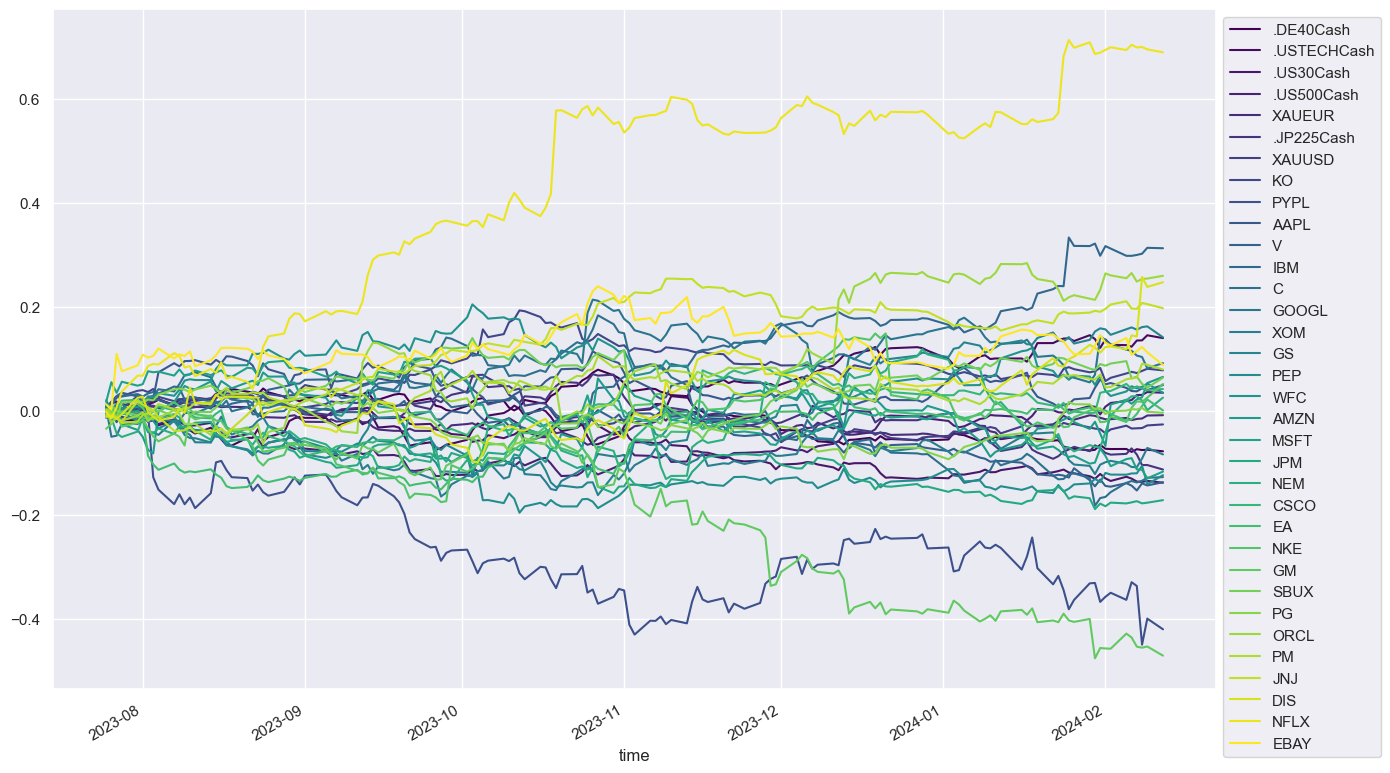

In [11]:
res, max_drawdown, max_returns, lists = process_symbols(results_df, reg=True)
# Кумулятивная доходность стратегий на тестовом наборе
data = res.dropna().loc[results_df['Start_test_date'].max():results_df['Start_val_date'].max()]
ax = data.cumsum().plot(figsize=(15,10), colormap='viridis')
ax.legend(loc='best', bbox_to_anchor=(1, 1))

### Фильтрую  несколько тикеров с максимальной доходностью

<Axes: xlabel='time'>

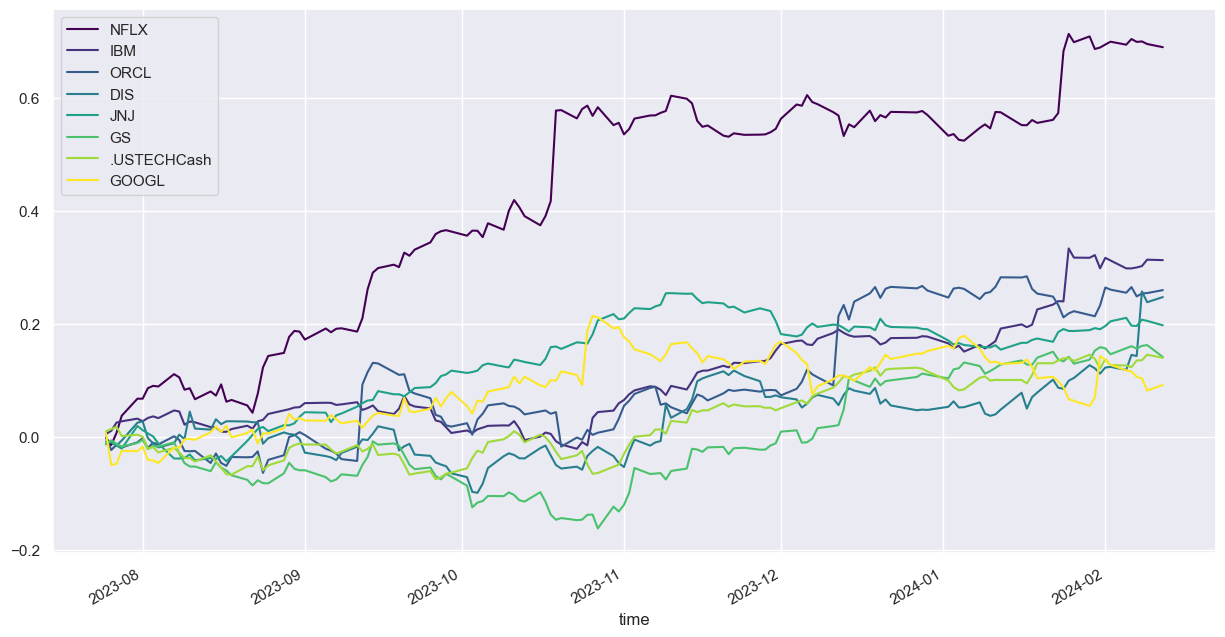

In [12]:
selected_symbols = data.cumsum().loc[data.index[-1]].nlargest(8).index
data.cumsum()[selected_symbols].plot(figsize=(15,8), colormap='viridis')

#  Оптимизация портфеля и диверсификация рисков

В качестве критерия оптимизации использую функцию полезности с коэффициентом неприятия риска (CRRA — Constant Relative Risk Aversion). Для минимизации с помощью алгоритма градиентного спуска исходная функция разложена в ряд Тейлора четвёртого порядка.

In [13]:
def SK_criterion(weights, data):
    """ 
     Args: -weight (ndarray numpy): Вес для портфеля 
     -data (ndarray numpy): Доходность (returns) 

      Return: критерий оптимизации портфеля 

    """
    
    # Параметры
    Lambda = 3 # коэффициент неприятия риска
    W = 1 # базовый уровень дохода
    Wbar = 1 + 0.25 / 100 # базовый уровень дохода с нормировкой

    # Вычисление доходности портфеля с учётом весовых коэффициентов
    portfolio_return = np.dot(data, weights)

    # Вычисление средней доходности, волатильности, асимметрии и эксцесса портфеля
    mean = np.mean(portfolio_return)
    std = np.std(portfolio_return)
    skewness = skew(portfolio_return)
    kurt = kurtosis(portfolio_return)

    # Вычисление критерия
    criterion = (Wbar ** (1 - Lambda) / (1 + Lambda) 
                 + Wbar ** (-Lambda) * W * mean 
                 - Lambda / 2 * Wbar ** (-1 - Lambda) * W ** 2 * std ** 2 
                 + Lambda * (Lambda + 1) / 6 * Wbar ** (-2 - Lambda) * W ** 3 * skewness 
                 - Lambda * (Lambda + 1) * (Lambda + 2) / 24 * Wbar ** (-3 - Lambda) * W ** 4 * kurt)
    
    criterion = -criterion
    return criterion


### Функция оптимизации и применение заданного критерия оптимизации

In [14]:
def optimization_portfolio(criterion, data):

    # Определение количества активов
    n = data.shape[1]

    # Инициализация значений весов
    x0 = np.ones(n)

    # Определение ограничений для задачи оптимизации
    cons = ({'type': 'eq', 'fun': lambda x: sum(abs(x)) - 1})

    # Установка границ для весов
    Bounds = [(0, 1) for i in range(0, n)]

    # Решение задачи оптимизации
    res_SK = minimize(criterion, x0, method="SLSQP",
                      args=(data), bounds=Bounds,
                      constraints=cons, options={'disp': True})

    # Получение результатов вычислений
    X = res_SK.x
    return X

### Фильтр по отобранным символам

In [15]:
# Фильтр по отобранным символам
res_filtered = res[selected_symbols.intersection(res.columns)]
max_drawdown_filtered = max_drawdown[selected_symbols.intersection(max_drawdown.columns)]
max_returns_filtered = max_returns[selected_symbols.intersection(max_returns.columns)]


Так как для разных тикеров может быть получена разная глубина истории, то для оптимизации параметров портфеля беру самую позднюю дату старта валидационной выборки

In [16]:
# тестовые и валидационные данные делю 50/50
start_test_date = results_df[results_df.Symbol.isin(selected_symbols)]['Start_test_date'].max()
end_test_date = results_df['Start_val_date'].max()

test_data = res_filtered.dropna().loc[start_test_date:end_test_date]
val_data = res_filtered.dropna().loc[end_test_date:]

X = optimization_portfolio(SK_criterion, test_data)
print(selected_symbols, np.round(X, 3), sep='\n')

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.6850120801967403
            Iterations: 15
            Function evaluations: 145
            Gradient evaluations: 15
Index(['NFLX', 'IBM', 'ORCL', 'DIS', 'JNJ', 'GS', '.USTECHCash', 'GOOGL'], dtype='object')
[0.156 0.121 0.    0.149 0.    0.204 0.21  0.16 ]


## Доходность после оптимизации весов

In [17]:
# средневзвешенный спред в зависимости от веса актива в портфеле
spread = round(np.dot(low_spread[low_spread.Symbol.isin(selected_symbols)]['Spread'], np.round(X, 3)), 5)

drawdown_portfolio = np.multiply(max_drawdown_filtered,np.transpose(X)).sum(axis=1)
max_returns_portfolio = np.multiply(max_returns_filtered,np.transpose(X)).sum(axis=1)

# Вычисление кумулятивной доходности портфеля
portfolio_return_test = np.multiply(test_data,np.transpose(X)).sum(axis=1)
portfolio_return_val = np.multiply(val_data,np.transpose(X)).sum(axis=1)

estimation.get_estimate(portfolio_return_val, spread=spread)


    -----------------------------------------------------------------------------
    Максимальная просадка: 10% 	
    Коэффициент Шарпа: -0.693 	 
    -----------------------------------------------------------------------------
    


### Оптимизация take profit

In [18]:
def find_best_tp(tp):
    tp = tp/100
    
    # Создание портфеля
    pf = pd.concat((drawdown_portfolio, portfolio_return_test, max_returns_portfolio), axis=1).dropna()-spread
    pf.columns = ["low", "Return", "high"]

    # Применение tp
    pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
    pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
    down = pf["Return"].values
    down = down[down<0] # убытки
    
    # коэффициент Шарпа
    return np.sqrt(260)*pf["Return"].mean()/down.std()

pd.DataFrame([find_best_tp(tp) for tp in np.linspace(0.5,10,30)],  index=np.linspace(0.5,10,30), columns=["Sharpe"])

,Sharpe
0.50000,13.05025
0.82759,13.27789
1.15517,10.25996
1.48276,10.16973
1.81034,7.51333
2.13793,8.66292
2.46552,7.61271
2.79310,7.29625
3.12069,6.94274
3.44828,6.38689


In [19]:
tp = 1.5/100
pf = pd.concat((drawdown_portfolio, portfolio_return_val, max_returns_portfolio), axis=1).dropna()-spread
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)

estimation.get_estimate(pf["Return"], spread=spread)


    -----------------------------------------------------------------------------
    Максимальная просадка: 10% 	
    Коэффициент Шарпа: -0.4 	 
    -----------------------------------------------------------------------------
    


### Оптимизация stop loss

In [20]:
def find_best_sl(sl):
    sl = sl/100
    
    # Создание портфеля
    pf = pd.concat((drawdown_portfolio, portfolio_return_test, max_returns_portfolio), axis=1).dropna()-spread
    pf.columns = ["low", "Return", "high"]

    # Применение sl
    pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
    pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)
    
    # коэффициент Шарпа
    return np.sqrt(260)*pf["Return"].mean()/pf["Return"].std()

pd.DataFrame([find_best_sl(sl) for sl in np.linspace(1,10,30)],  index=np.linspace(1,10,30), columns=["Sharpe"])

,Sharpe
1.00000,-1.37084
1.31034,-0.07197
1.62069,1.86883
1.93103,2.14544
2.24138,2.74866
2.55172,3.05327
2.86207,3.05327
3.17241,3.05327
3.48276,3.05327
3.79310,3.05327


In [21]:
sl = 7/100
pf = pd.concat((drawdown_portfolio, portfolio_return_val, max_returns_portfolio), axis=1).dropna()-spread

pf.columns = ["low", "Return", "high"]
pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)

estimation.get_estimate(pf["Return"], spread=spread)


    -----------------------------------------------------------------------------
    Максимальная просадка: 13% 	
    Коэффициент Шарпа: -1.914 	 
    -----------------------------------------------------------------------------
    


### Применение всех параметров выше, установка кредитного плеча

In [22]:
leverage = 1.8 # Кредитное плечо
tp = 1.5/100 # Тейк-профит
sl = 7 # Стоп-лосс

pf = (pd.concat((drawdown_portfolio, portfolio_return_val, max_returns_portfolio), axis=1).dropna()-spread)*leverage
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)

estimation.get_estimate(pf["Return"], spread=spread)


    -----------------------------------------------------------------------------
    Максимальная просадка: 9% 	
    Коэффициент Шарпа: 4.975 	 
    -----------------------------------------------------------------------------
    


Далее, стратегию следует протестировать непосредственно в терминале для сравнения с результатами тестирования на тестовых данных. Затем, применить в рельной торговле на микро-счёте, либо на демосчёте и сравнить результаты с тестовыми.